In [ ]:
import matplotlib.pyplot as plt

import numpy as np 


import h5py 

import pennylane as qml 

import torch

from qracle.utils import get_gnn_results
from tqdm.notebook import tqdm
from qracle.ansatz import CZRXRYLayer

In [ ]:
valid_file = 'data/heisenberg_xyz_valid.h5'

In [6]:
n_qubits = 4
dev = qml.device('lightning.qubit', wires = n_qubits)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_cells = [n_qubits]


n_layers = 1

old_init = []
dgnn_init = []
gin_init = []
diff_init = []

with h5py.File(valid_file, 'r') as f:
    coupling_constant_group = f['coupling_const']
    dgnn_model_param_group = f['dgnn_model_param']
    gin_model_param_group = f['gin_model_param']
    diff_model_param_group = f['diff_model_param']
    loss_history_group = f['loss_history']
    for key in dgnn_model_param_group.keys():
        dgnn_model_param = dgnn_model_param_group[key][:]
        gin_model_param = gin_model_param_group[key][:]
        diff_model_param = diff_model_param_group[key][:]
        c_const = coupling_constant_group[key][:]
        dgnn_init_param = dgnn_model_param.reshape(n_layers, n_qubits, 2)
        gin_init_param = gin_model_param.reshape(n_layers, n_qubits, 2)
        diff_init_param = diff_model_param.reshape(n_layers, n_qubits, 2)
        dgnn_params = torch.tensor(dgnn_init_param, requires_grad=True, device=device)

        gin_params = torch.tensor(gin_init_param, requires_grad=True, device=device)

        diff_params = torch.tensor(diff_init_param, requires_grad=True, device=device)
        heisenberg_xyz_h = qml.spin.heisenberg('chain', n_cells, coupling=c_const)
        loss_history = loss_history_group[key][:]
        old_init.append(loss_history[0])
        @qml.qnode(dev, interface='torch', diff_method='adjoint')
        def vqe_circuit(h, params, n_qubits, n_layers):
            for i in range(n_layers):
                CZRXRYLayer(params[i], n_qubits)
            return qml.expval(h)
                
        dgnn_loss = vqe_circuit(heisenberg_xyz_h, dgnn_params, n_qubits, n_layers)
        gin_loss = vqe_circuit(heisenberg_xyz_h, gin_params, n_qubits, n_layers)
        diff_loss = vqe_circuit(heisenberg_xyz_h, diff_params, n_qubits, n_layers)
        diff_init.append(diff_loss.item())

        dgnn_init.append(dgnn_loss.item())
        gin_init.append(gin_loss.item())


In [26]:
def get_random_data(valid_file, n_qubits = 4, n_layers = 1, n_exp = 10): 
    labels = []
    data_group = []
    torch.manual_seed(42)
    for i  in tqdm(range(n_exp), desc = 'Running  experiment'):
        label = f'Random{i}'
        labels.append(label)
        rand_init = []

        with h5py.File(valid_file, 'r') as f:
            coupling_constant_group = f['coupling_const']
            loss_history_group = f['loss_history']
            for key in loss_history_group.keys():

                c_const = coupling_constant_group[key][:]
                random_params = torch.randn((n_layers, n_qubits, 2), requires_grad=True, device=device)

                heisenberg_xyz_h = qml.spin.heisenberg('chain', n_cells, coupling=c_const)
                @qml.qnode(dev, interface='torch', diff_method='adjoint')
                def vqe_circuit(h, params, n_qubits, n_layers):
                    for i in range(n_layers):
                        CZRXRYLayer(params[i], n_qubits)
                    return qml.expval(h)
                        
           
                rand_loss = vqe_circuit(heisenberg_xyz_h, random_params, n_qubits, n_layers)

                rand_init.append(rand_loss.item())
        data_group.append(np.array(rand_init))
    return data_group, labels


In [27]:
rand_exp_group, rand_labels = get_random_data(valid_file, n_qubits = 4, n_layers = 1, n_exp = 10)

Running  experiment:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_120752/3631920054.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, positions=[2*i for i in range(len(data))], labels=labels, whis=[0, 100])


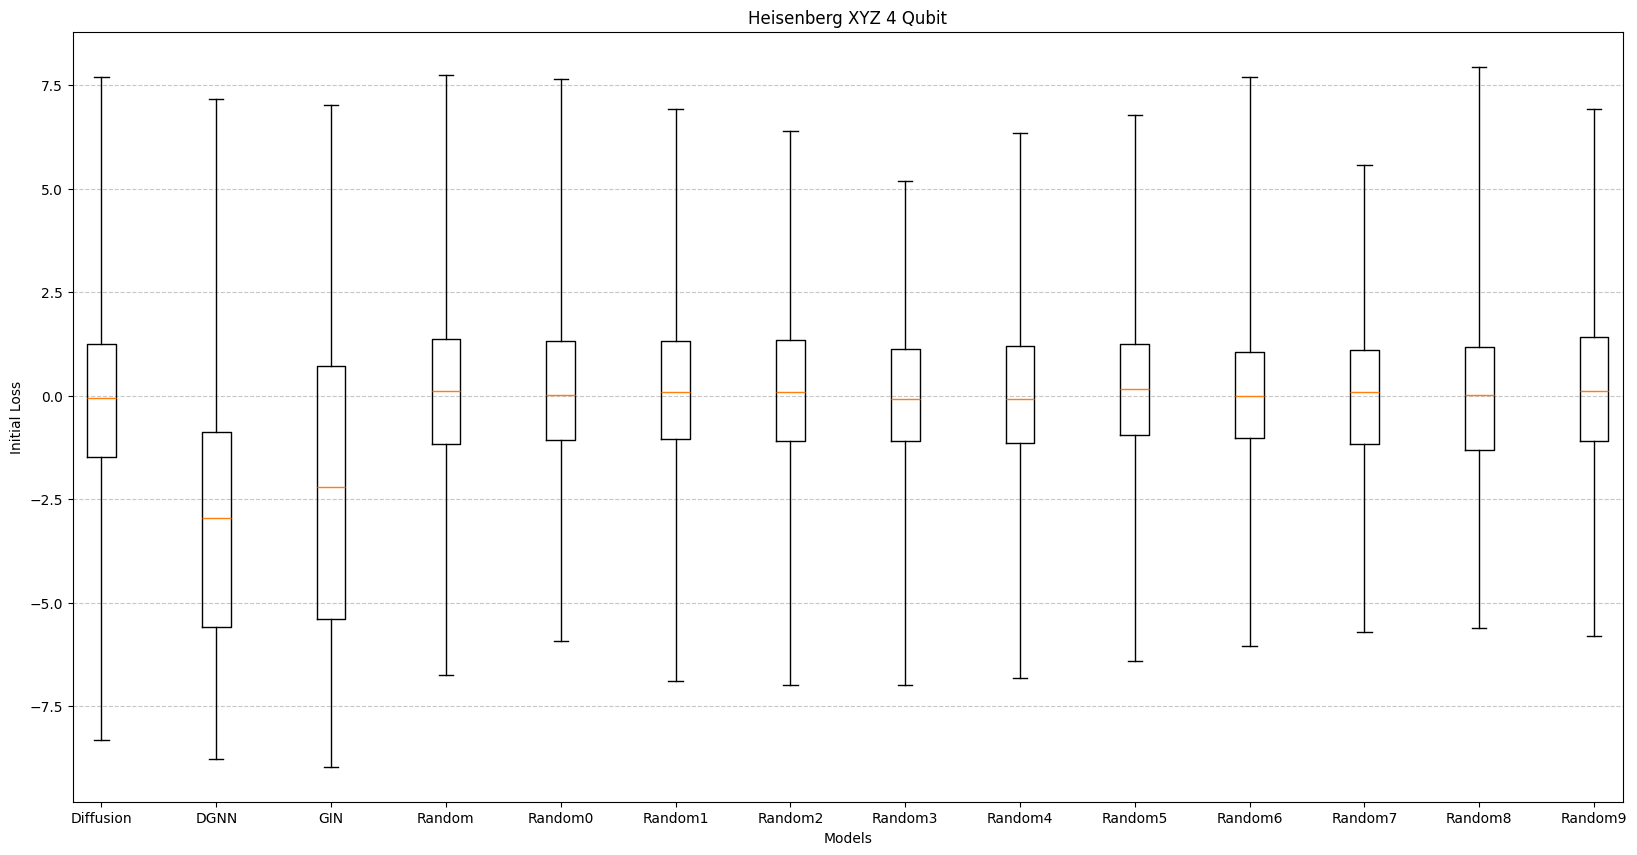

In [31]:
random_data = np.array(old_init)

diff_data = np.array(diff_init)

dgnn_data = np.array(dgnn_init)

gin_data = np.array(gin_init)


model_data = [diff_data, dgnn_data, gin_data, random_data]

data = model_data + rand_exp_group

labels = ['Diffusion', 'DGNN', 'GIN', 'Random'] + rand_labels

plt.figure(figsize=(20, 10))
plt.boxplot(data, positions=[2*i for i in range(len(data))], labels=labels, whis=[0, 100])

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Dashed lines, semi-transparent

plt.title('Heisenberg XYZ 4 Qubit')
plt.xlabel('Models')
plt.ylabel('Initial Loss')
plt.show()
